# Проект: вариант 2

Проект включает три задания:

- Задание 1. A/B–тестирование
- Задание 2. SQL
- Задание 3. Python

## Задание 1. A/B–тестирование

### - Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### - Входные данные

В качестве входных данных 4 csv-файла:

- **groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- **groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- **active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- **checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### - Вопросы

Найти ответ на следующие вопросы:

- На какие метрики смотрим в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

## Общий план исследования

### 1.1. **Препроцессинг данных:**
    - Посмотрим на данные
    - Построим графики
    
### 1.2. **Формулировка гипотез:**
    - Выберем метрику
    - Построим графики
    - Сформулируем предположения

    
### 1.3. **Проверка гипотез:**
     - Выбираем подходящий тест
     - Тестируем
     
     
### 1.4. **Подведение итогов:**
    - Сформулировать выводы
    - Какие действия нужно предпринять разработчикам / бизнесу.


### Импорт библиотек

In [14]:
# Анализ данных
import numpy as np
import pandas as pd
import scipy.stats as ss
import requests
from urllib.parse import urlencode

# Визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Статистический анализ
import pingouin as pg
from pingouin import power_ttest2n,  power_chi2

import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.power import TTestIndPower

### Блок функции построения графика

In [28]:
def create_bar_plot_with_customization(data, 
                                       x_column, 
                                       y_column,
                                       color_A="gray",
                                       color_B="orange",
                                       title=None, 
                                       x_label=None, 
                                       y_label=None,
                                       legend_1=None,
                                       legend_2=None,
                                       annotate=True,
                                       x_size=12,
                                       y_size=6,
                                       h=50,
                                       decimal_places=1):
    
    colors = {data[x_column].unique()[0]: color_A, data[x_column].unique()[1]: color_B}
    
    plt.figure(figsize=(x_size, y_size))
    ax = sns.barplot(data=data, x=x_column, y=y_column, palette=colors.values(), saturation=0.9)

    # Подпись графика (используем значение по умолчанию, если не указано пользователем)
    if title is not None:
        plt.title(title)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    # Легенда (используем значение по умолчанию, если не указано пользователем)
    if legend_1 and legend_2 is not None:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=legend_1 if color == color_A else legend_2) for color in colors.values()]
        plt.legend(handles=legend_labels, title='Легенда')
    else:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label if color == color_A else label) for label, color in colors.items()]
        plt.legend(handles=legend_labels, title='Легенда')
    
    # Значения столбцов
    if annotate:
        for p in ax.patches:
            value = round(p.get_height(), decimal_places)
            ax.annotate(f'{value:.{decimal_places}f}', (p.get_x() + p.get_width() / 2., p.get_height() + h),
                        ha='center', va='baseline', fontsize=12, color='black')

### Блок функции загрузки данных

In [17]:
def download_files_with_api(public_keys_sep):
    
    """
    Загружает файлы с использованием API Яндекс.Диска.

    Параметры:
    - public_keys_sep (list): Список кортежей, где каждый кортеж содержит два элемента:
                             ссылку на файл (public_key) и разделитель CSV-файла (sep).

    Возвращает:
    - list: Список DataFrame, каждый из которых представляет собой данные из соответствующего файла.

    Пример использования:
    public_keys_sep = [
                       ('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'),
                       ('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',')
                      ]
                       
    dataframes = download_files_with_api(public_keys_sep)
    df_1, df_2 = dataframes
    
    """

    # Список для хранения загруженных DataFrame
    dataframes = []

    for public_key, sep in public_keys_sep:
        
        # Получаем URL для загрузки файла
        final_url = base_url + urlencode(dict(public_key=public_key))
        response = requests.get(final_url)
        download_url = response.json()['href']

        # Загружаем файл в DataFrame
        download_response = requests.get(download_url)
        df = pd.read_csv(download_response.url, sep=sep)

        # Добавляем DataFrame в список
        dataframes.append(df)

    return dataframes

### 1.1. Препроцессинг данных

1.1.1. Импорт исходных данных

In [20]:
# Список из кортежей (публичный ключ, разделитель)
public_keys_sep = [
                    ('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';'),  # groups.csv
                    ('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ','),  # groups_add.csv
                    ('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ','),  # active_studs.csv
                    ('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')   # checks.csv
                  ]

# Загружаем данные
dataframes = download_files_with_api(public_keys_sep)

# dataframes содержит загруженные DataFrame в виде списка 
groups, groups_add, active_studs, checks = dataframes

**1.1.2. Информация о принадлежности к группам**

Данные выглядят следующим образом.

In [29]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


**Общая информация о данных**

In [30]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Пропуски отсутуствуют. Размер DataFrame составляет 74 484 строк.

**Проверка на наличие дубликатов**

In [31]:
groups.id.duplicated().sum()

0

**Размер групп А и B**

Оценим размер групп А и В

In [32]:
counts_A_B = groups.grp.value_counts()\
                   .to_frame()\
                   .reset_index()\
                   .rename(columns={'index': 'grp', 
                                     'grp': 'group_size'})\
                   .sort_values(by='group_size', ascending=True)

Визуализируем количестов пользователей в группах

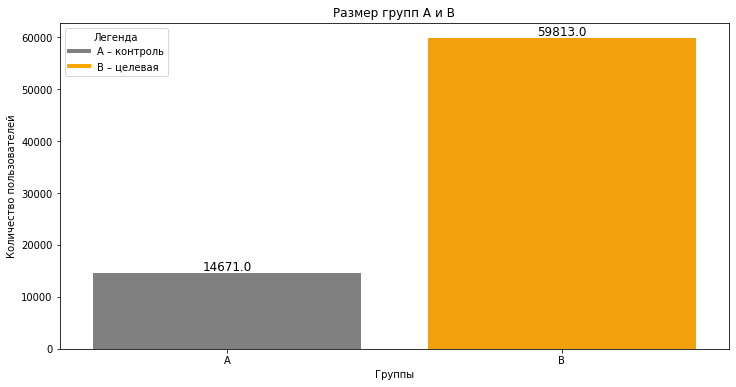

In [33]:
create_bar_plot_with_customization(data=counts_A_B, 
                                   x_column='grp', 
                                   y_column='group_size', 
                                   title='Размер групп А и В', 
                                   x_label='Группы', 
                                   y_label='Количество пользователей',
                                   h=500,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая'
                                  )

**1.1.2. Дополнительная информация о пользователях для данных предоставленных спустя 2 дня**

Данные выглядят следующим образом.

In [34]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


**Общая информация о данных**

In [35]:
groups_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


Пропуски отсутуствуют. Размер DataFrame составляет 92 строк.

**Проверка на наличие дубликатов**

In [36]:
groups_add.id.duplicated().sum()

0

**Размер групп А и B для данных предоставленных спустя 2 дня**

Оценим размер групп А и В

In [37]:
counts_A_B_2_days = groups_add.grp.value_counts()\
                                  .to_frame()\
                                  .reset_index()\
                                  .rename(columns={'index': 'grp', 
                                                    'grp': 'group_size'})\
                                  .sort_values(by='group_size', ascending=True)

Визуализируем количество пользователей в группах

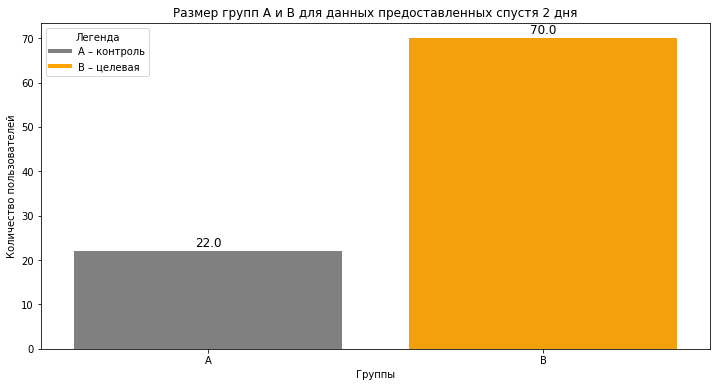

In [38]:
create_bar_plot_with_customization(data=counts_A_B_2_days, 
                                   x_column='grp', 
                                   y_column='group_size', 
                                   title='Размер групп А и В для данных предоставленных спустя 2 дня', 
                                   x_label='Группы', 
                                   y_label='Количество пользователей',
                                   h=1,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая'
                                  )

**1.1.3. Сопосталение groups и groups_add**

Файл `groups_add.csv` является дополнительным и появился спустя 2 дня после передачи основных данных. Рассмотрим возможные влияния и факторы, которые следует учитывать **i**:

Добавление **"новых"** пользователей:

- Если в `groups_add.csv` содержатся данные о пользователях, которые были добавлены после начала эксперимента, это может повлиять на общую картину.
- Новые пользователи могут иметь различное поведение и характеристики по сравнению с теми, кто был включен в исходный эксперимент.

Изменение состава групп:

- Файл может содержать информацию об изменении принадлежности к группам для некоторых пользователей. Например, если кто-то изначально попал в контрольную группу (A), а затем был перемещен в целевую группу (B) или наоборот.
- Это может внести дополнительную сложность в интерпретацию результатов.

Сдвиг во времени:

- Файл, полученный спустя 2 дня, может содержать данные о действиях пользователей после окончания эксперимента.

**i** - это только предположения

**Проверим наши предположения о `groups_add`**

Объеденим `groups` с `groups_add` через `outer`, чтобы не потерять данные.

In [39]:
# Объединение данных
merged_groups = pd.merge(groups, groups_add, on='id', how='outer', suffixes=('_original', '_add'))

Выведем результат объединения `groups` с `groups_add`

In [40]:
merged_groups.head()

,id,grp_original,grp_add
0,1489,B,NaN
1,1627,A,NaN
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN


Проверим действительно ли `groups_add` может повлиять на изначальный состав `groups` A и B.

In [41]:
# Поиск изменений в принадлежности к группам
changed_users = merged_groups[ 
                               (merged_groups['grp_original'] != merged_groups['grp_add']) 
                              & 
                               (merged_groups['grp_original'] == pd.notna(merged_groups['grp_original'])) 
                             ]

Количество изменений в принадлежности к группам

In [42]:
changed_users.shape[0]

0

Провереим **"новых"** пользователей (т.е. изначально не попавших в `groups`)

In [43]:
# Поиск новых пользователей
new_users = merged_groups[ pd.notna(merged_groups['grp_original']) == False ]

Количество новых пользователей

In [44]:
new_users.shape[0]

92

**Промежуточный вывод по разделу 1.1.3:**

- Предположение об изменении состава групп не подтвердилось.
- По результатам сравнения `groups` с `groups_add` мы можем сказать, что `groups_add` содержит информацию о принадлежности пользователй к группам, которые не попали в файл `groups`. Однка у нас недостаточно данных, что бы утверждать о времени включения пользователей из `groups_add` в эксперемент. Попробуем выяснить в дальнейшем анализе с учтом `active_studs` и `checks`

**Объедененный DataFrame по `groups` с `groups_add`**

Дополним `groups` данными из `groups_add` через concat для использования в дальнейшем анализе.

In [45]:
# Объединение данных
concat_groups = pd.concat([groups, groups_add])

Проверим результата объединения

In [46]:
if concat_groups.shape[0] - groups.shape[0] == new_users.shape[0]:
    print(f'Объединение успешно!')
else:
    print(f'Что то пошло не так!')

Объединение успешно!


Перед формированием итогового DataFrame, с целью выбора метрик и оценки статистически значимых различий,

рассмотри оставшиеся данные по `active_studs` и `checks`

**1.1.4. Информация о пользователях, которые зашли на платформу в дни проведения эксперимента**

Данные выглядят следующим образом.

In [47]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


**Общая информация о данных**

In [48]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


Пропуски отсутуствуют. Размер DataFrame составляет 8 341 строк.

**Проверка на наличие дубликатов**

In [49]:
active_studs.duplicated().sum()

0

**1.1.5. Информация об оплатах пользователей в дни проведения эксперимента**

Данные выглядят следующим образом.

In [50]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


**Общая информация о данных**

In [51]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


Пропуски отсутуствуют. Размер DataFrame составляет 541 строку.

**Проверка на наличие дубликатов**

In [52]:
checks.duplicated().sum()

0

**1.1.6. Сопоставление `groups_add` с `active_studs` и `checks`**

Проверим содержиться ли информация о пользователях из `groups_add` в `active_studs` и `checks`

**Объеденим `groups_add` с `active_studs` через `inner`**

In [53]:
# Объединение данных
merged_groups_add_with_active_studs = pd.merge(groups_add, 
                                               active_studs, 
                                               left_on='id', 
                                               right_on='student_id', 
                                               how='inner')\
                                               .drop(columns={'student_id'})

Посмотри на распределение пользователей по группам из `groups_add`, которые участовали в эксперементе

In [54]:
users_add_participated_in_experiment = merged_groups_add_with_active_studs.grp.value_counts()\
                                                                          .to_frame()\
                                                                          .reset_index()\
                                                                          .rename(columns={'index': 'grp', 
                                                                                            'grp': 'group_size'})\
                                                                          .sort_values(by='group_size', ascending=True)

Визуализируем количестов пользователей в группах

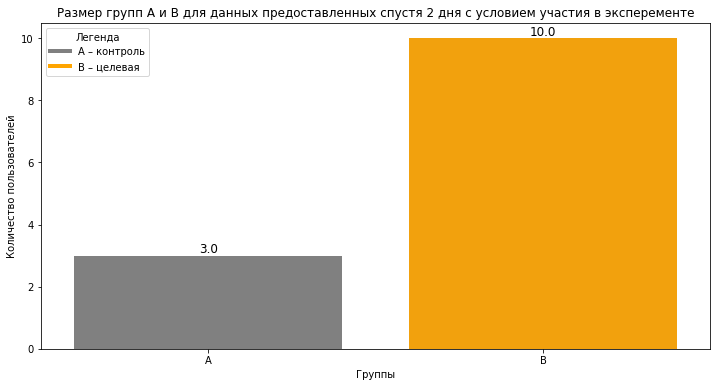

In [55]:
create_bar_plot_with_customization(data=users_add_participated_in_experiment, 
                                   x_column='grp', 
                                   y_column='group_size', 
                                   title='Размер групп А и В для данных предоставленных спустя 2 дня с условием участия в эксперементе', 
                                   x_label='Группы', 
                                   y_label='Количество пользователей',
                                   h=0.1,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая'
                                  )

Количество пользователей из `groups_add`, которые зашли на платформу в дни проведения эксперимента `active_studs`.

In [56]:
merged_groups_add_with_active_studs.shape[0]

13

**Объеденим `groups_add` с `checks` через `inner`**

In [57]:
# Объединение данных
merged_groups_add_with_checks = pd.merge(groups_add, 
                                         checks, 
                                         left_on='id', 
                                         right_on='student_id', 
                                         how='inner')\
                                         .drop(columns={'student_id'})

Выведем информацию о "новом" пользователе, который что-то оплатил

In [58]:
merged_groups_add_with_checks

,id,grp,rev
0,5740903,B,1900.0


Количество пользователей из `groups_add`, которые что-то оплатили в `checks`.

In [59]:
merged_groups_add_with_checks.shape[0]

1

**Объеденим результат `merged_groups_add_with_active_studs` с `checks` через `inner`**

In [60]:
# Объединение данных
merged_groups_add_with_active_studs_with_checks = pd.merge(merged_groups_add_with_active_studs, 
                                                           checks, 
                                                           left_on='id', 
                                                           right_on='student_id', 
                                                           how='inner')\
                                                          .drop(columns={'student_id'})

Выведем информацию о "новом" пользователе, который участвовал в эксперементе и что-то оплатил

In [61]:
merged_groups_add_with_active_studs_with_checks

,id,grp,rev
0,5740903,B,1900.0


Количество пользователей из `groups_add`, которые что-то оплатили и при этом участвовали в эксперементе.

In [62]:
merged_groups_add_with_active_studs_with_checks.shape[0]

1

**Промежуточный вывод по разделу 1.1.6:**

- Выявлено **13** пользователей из `groups_add`, которые учавствовали в эксперементе.
- Из **13** пользователей **1** произвел оплату на сумму **1900** под **id 5740903** в целевой группе **B**.
- Распределение пользователей по группам участвовших в эксперементе схоже  с данными `groups`.

Зафиксировано, что часть пользователей из `groups_add` участвовало в эксперементе и частично попало в группу **B**. 
Информация о пользователях участвовавших в эксперементе `groups_add` содержиться в `active_studs`.

**1.1.7. Неактивные пользователи**

Пользователи оплативншие курс, которые не заходили на платформу в период эксперемента

In [161]:
not_active_studs_by = concat_groups[
                                       (concat_groups['id'].isin(checks['student_id']))
                                    & 
                                      ~(concat_groups['id'].isin(active_studs['student_id']))
                                   ]

Количество неактивных пользователей оплативших курсы

In [162]:
not_active_studs_by.shape[0]

149

Пользователи не оплатившие курс, которые не заходили на платформу в период эксперемента

In [165]:
not_active_studs_not_by = concat_groups[
                                          ~(concat_groups['id'].isin(checks['student_id']))
                                        & 
                                          ~(concat_groups['id'].isin(active_studs['student_id']))
                                        ]

Количества неактивных кользователей не оплативших курсы

In [164]:
not_active_studs_not_by.shape[0]

66086

Объеденим результаты по пользователям купившим и не купившим курсы, которые не заходили на платформу в период эксперемента

In [167]:
not_active_studs = pd.concat([not_active_studs_by, not_active_studs_not_by])

Проверим коректность объединения не активных пользователей относительно общего количества пользователей в выборке

In [169]:
if not_active_studs.shape[0] + active_studs.shape[0] == concat_groups.shape[0]:
    print(f'Объединение успешно!')
else:
    print(f'Что то пошло не так!')

Объединение успешно!


Дополним данные о неактивных пользователях информацией cвязанной с покупкаи курса.\
Переименуем столбец `id` в `student_id` для удобства и порядка.

In [172]:
# Объединение данных с checks
experiment_users_data_not_active = pd.merge(not_active_studs, 
                                            checks,
                                            left_on='id',
                                            right_on='student_id',  
                                            how='left')\
                                      .drop(columns={'student_id'})\
                                      .rename(columns={'id': 'student_id'})

Выведем результат объединения для проверки

In [183]:
experiment_users_data_not_active.head()

,student_id,grp,rev
0,3185,B,690.0
1,25973,B,690.0
2,26280,B,690.0
3,100645,B,630.0
4,102534,B,580.0


Проверим полноту данных по оплате курсов относительно итогового количества произведенным покупок

In [182]:
if experiment_users_data_not_active.rev.notna().sum() + experiment_users_data_active.rev.notna().sum() == checks.shape[0]:
    print(f'Объединение успешно!')
else:
    print(f'Что то пошло не так!')

Объединение успешно!


Посмотри на распределение неактиных пользователей

In [187]:
experiment_users_data_not_active = experiment_users_data_not_active.grp.value_counts()\
                                                                          .to_frame()\
                                                                          .reset_index()\
                                                                          .rename(columns={'index': 'grp', 
                                                                                            'grp': 'group_size'})\
                                                                          .sort_values(by='group_size', ascending=True)

Визуализируем количестов неактивных пользователей по группам

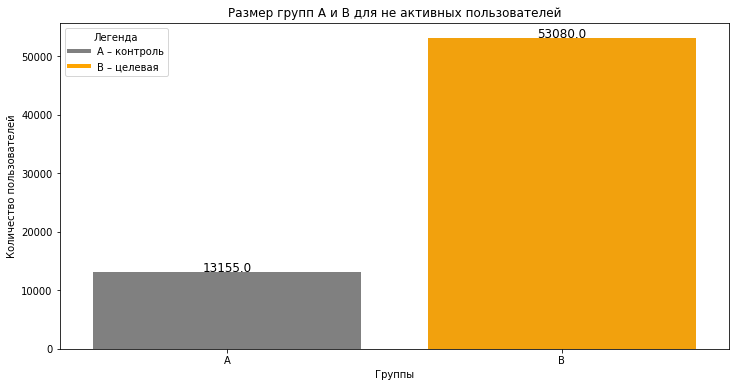

In [194]:
create_bar_plot_with_customization(data=experiment_users_data_not_active, 
                                   x_column='grp', 
                                   y_column='group_size', 
                                   title='Размер групп А и В для не активных пользователей', 
                                   x_label='Группы', 
                                   y_label='Количество пользователей',
                                   h=100,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая'
                                  )

**1.1.8. Результирующий DataFrame по активным пользователям**

С целью сохранения корректности сравнения результатов, оставим только тех пользователей, которые приняли участие в эксперементе по данным `active_studs`

Объеденим результаты по `active_studs` с дополненной информацией по `concat_groups` (содержит данные из: `groups`, `groups_add`) через `left` [п 1.1.3.], что бы не потерять данные из `active_studs`.

In [185]:
# Объединение данных с concat_groups
experiment_users_data = pd.merge(active_studs, 
                                 concat_groups, 
                                 left_on='student_id', 
                                 right_on='id', 
                                 how='left')\
                                 .drop(columns={'id'})
# Объединение данных с checks
experiment_users_data = pd.merge(experiment_users_data, 
                                 checks, 
                                 on='student_id',  
                                 how='left')

Выведем результат объединения для проверки

In [186]:
experiment_users_data.head()

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


Проверка на сооответствие количества принявших участие в эксперементе пользователей в сравнении с `active_studs`

In [121]:
if experiment_users_data.shape[0] == active_studs.shape[0]:
    print(f'Соответствует - {active_studs.shape[0]}')
else:
    print(f'Не соответствует!')

Соответствует - 8341


### 1.2. Формулировка гипотез

**1.2.1. Выбор метрик**

**Конверсия в покупку (оплату, CR):** отношение количества пользователей совершивших оплату к общему количеству пользователей. Позволит оценить, какую долю пользователей удалось привлечь к выполнению целевого действия.

1. Оценка эффективности изменений:
    - Конверсия позволяет оценить, насколько успешно новая механика оплаты влияет на желаемое действие пользователей. Если конверсия в группе A выше, чем в группе B (или наоборот), это может указывать на эффективность или неэффективность внесенных изменений.
    
    
2. Изменение в пользовательском поведении:
    - Высокая конверсия может свидетельствовать о том, что новая механика оплаты более привлекательна для пользователей, и они более склонны совершать целевое действие. Низкая конверсия, напротив, может указывать на проблемы или нежелательные изменения, которые отталкивают пользователей.
    
    
3. Оценка воздействия на выручку:
    - Высокая конверсия не всегда гарантирует высокую выручку, но она является важным фактором. Например, если конверсия высокая, но средний чек низкий, это может указывать на необходимость дополнительных исследований по повышению среднего чека.
    
    
4. Принятие решений на основе данных:
    - Конверсия предоставляет ясную и краткую метрику, на основе которой можно принимать решения. Она может быть использована для сравнения результатов в разных группах и определения того, стоит ли расширять новую механику оплаты на всех пользователей.
    
Таким образом, конверсия является важным индикатором успешности внедрения изменений в механику оплаты и может помочь в принятии обоснованных решений на основе данных.

**Средний чек:** Рассчитать средний чек для тех студентов, у которых есть данные о выручке. Это позволит определить средний объем трат каждого пользователя, который совершил транзакцию.

1. Оценка Финансового Влияния:
    - Средний чек позволяет оценить, как изменения в механике оплаты влияют на средний объем трат каждого пользователя. Если ARPU увеличивается, это может быть положительным сигналом.
    
    
2. Принятие Решений о Монетизации:
    - Информация о среднем чеке полезна при принятии решений о монетизации и ценообразовании. Высокий ARPU может обеспечить дополнительные возможности для максимизации выручки.
    
Сочетание **CR** c **Средний чек** позволит оценить эффективность внесенных изменений в систему оплаты с учетом дохода на одного пользователя.

**Примечание:**

При наличии информации о времени, можно было бы учесть Retention (удержание) чтобы понять, сколько пользователей возвращаются и продолжают совершать транзакции.

**1.2.2. Расчет выбранных метрик**

**Конверсия в покупку (CR)**

Создадим дополниетльный столбец с указанием:
- `0` - для `NaN` значений 
- `1` - при наличии транзакции в столбце **rev**.

In [45]:
# Создание столбца в зависимости от значения в столбце rev
experiment_users_data['rev_bin'] = np.where(experiment_users_data['rev'].isna(), 0, 1)

Сгруппирем данные по принадлежности к группам и транзакциям

In [46]:
count_users = experiment_users_data.groupby(['grp', 'rev_bin'], as_index=False)\
                                   .agg({'student_id': 'count'})\
                                   .rename(columns={'student_id': 'count_users'})

Оставим только данные с произведенной оплатой, т.е. `rev_bin = 1`

In [47]:
count_paying_users = count_users[ count_users['rev_bin'] == 1 ].drop(columns={'rev_bin'})\
                                                               .rename(columns={'count_users': 'count_paying_users'})

Количество пользователей в каждой группе

In [48]:
A = experiment_users_data.grp.value_counts()[1]
B = experiment_users_data.grp.value_counts()[0]

Расчитаем конверсию в зависимости от принадлежности к группе

In [49]:
count_paying_users['CR'] = count_paying_users.apply(lambda x: x['count_paying_users'] / A 
                                                    if        x['grp'] == 'A' 
                                                    else      x['count_paying_users'] / B, axis=1)

Выведем результат округленный до 3 знаков после разделителя

In [50]:
count_paying_users.CR = round(count_paying_users.CR, 3)
count_paying_users

,grp,count_paying_users,CR
1,A,78,0.051
3,B,314,0.046


Визуализирем результат расчета конверсии для пользователей выполневших покупку с рапсределением по группам

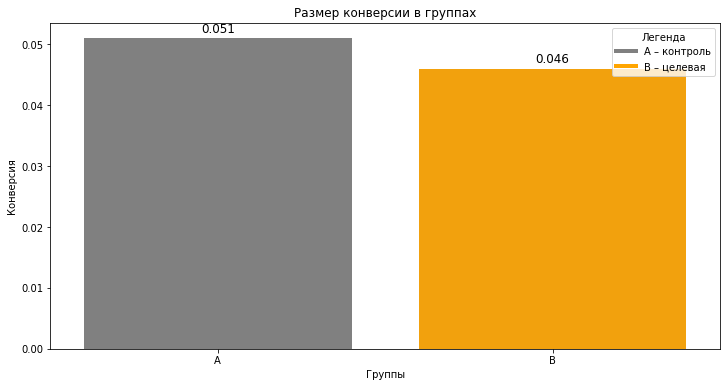

In [51]:
create_bar_plot_with_customization(data=count_paying_users, 
                                   x_column='grp', 
                                   y_column='CR', 
                                   title='Размер конверсии в группах', 
                                   x_label='Группы', 
                                   y_label='Конверсия',
                                   h=0.001,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая',
                                   decimal_places=3
                                  )

**Средний чек**

Сгруппирем данные по принадлежности к группам и транзакциям

In [52]:
mean_check = experiment_users_data.groupby(['grp', 'rev_bin'], as_index=False)\
                                  .agg({'rev': 'mean'})\
                                  .rename(columns={'rev': 'mean_check'})\
                                  .round(1)

Оставим только данные с произведенной оплатой, т.е. `rev_bin = 1`

In [53]:
mean_check = mean_check[ mean_check['rev_bin'] == 1 ].drop(columns={'rev_bin'})

Выведем результат округленный до 1 знака после разделителя

In [54]:
mean_check

,grp,mean_check
1,A,933.6
3,B,1257.9


Визуализирем результат расчета среднего чека для пользователей выполневших покупку с рапсределением по группам

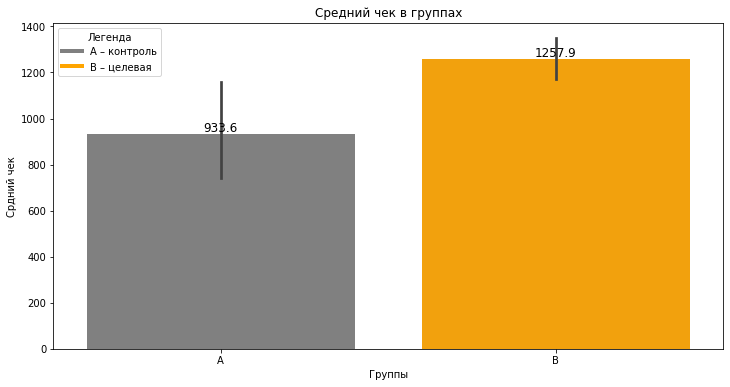

In [55]:
create_bar_plot_with_customization(data=experiment_users_data, 
                                   x_column='grp', 
                                   y_column='rev', 
                                   title='Средний чек в группах', 
                                   x_label='Группы', 
                                   y_label='Срдний чек',
                                   h=10,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая',
                                   decimal_places=1
                                  )

### 1.3. Проверка гипотез

**1.3.1. Гипотезы**

**Конверсия в покупку**

**H0:** Новая механика оплаты  курсов не влияет на конверсию (CR)

**H1:** Новая механика оплаты  курсов оказывает статистически значимое влияние на конверсию (CR)

**Средний чек**

**H0:** Средний чек контрольной (А) и целивой (В) групп не различается

**H1:** Средний чек контрольной (А) и целивой (В) групп обладает статистически значимыми различиями

**1.3.2. Конверсия в покупку**

**Размер выборки**

Сгруппирем данные по А и В. Оценим размер групп.

In [56]:
count_experiment_users = experiment_users_data.grp.value_counts()\
                                              .to_frame()\
                                              .reset_index()\
                                              .rename(columns={'index': 'grp', 
                                                                'grp': 'group_size'})\
                                              .sort_values(by='group_size', ascending=True)

Визуализирем распределение наблюдений по группам А и В.

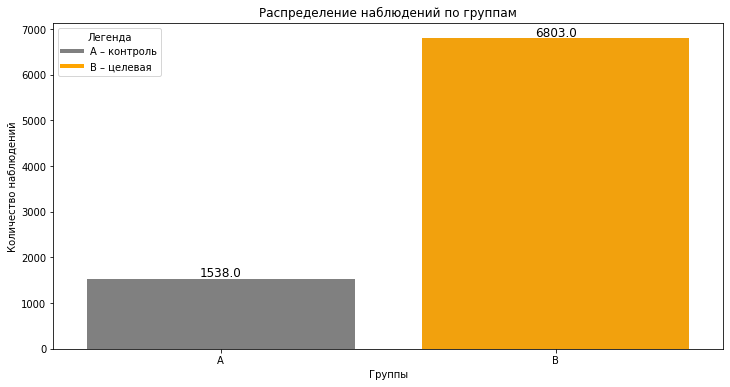

In [57]:
create_bar_plot_with_customization(data=count_experiment_users, 
                                   x_column='grp', 
                                   y_column='group_size', 
                                   title='Распределение наблюдений по группам', 
                                   x_label='Группы', 
                                   y_label='Количество наблюдений',
                                   h=50,
                                   legend_1 = 'А – контроль',
                                   legend_2 = 'B – целевая',
                                   decimal_places=1
                                  )

**Тестирование гипотез**

В качестве стат. теста выбран **Критерий хи-квадрат**.

Обоснование:
- Анализ таблицы сопряженности любого размера, где значения ожидаемых и наблюдаемых частот в каждой ячейке больше 10.
- Тип метрики относиться к пропорциям.
- Независимость отдельных наблюдений **[i]** 

**i** - Так как в исходных данных отсутсвовали дубликаты пользователей, предположим что была посчитана средняя стоимость заказа одного пользователя, которая в последствие сравнивалась между группами. В результате удалось избежать зависимости стоимости заказов от пользователей. Технически получается, что мы рассматриваем не совсем "Средний чек", примем допущение и оставим условное название.

In [58]:
expected, observed, stats = pg.chi2_independence(experiment_users_data, 
                                                 x='grp',
                                                 y='rev_bin')

Ожидаемые значения таблицы сопряжения:

In [59]:
expected

rev_bin,0,1
grp,,
A,1465.718979,72.281021
B,6483.281021,319.718979


Фактические значения таблицы сопряжения:

In [60]:
observed

rev_bin,0,1
grp,,
A,1460.5,77.5
B,6488.5,314.5


Результата применения **Критерий хи-квадрат**.

In [61]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.484808,1.0,0.486252,0.007624,0.107123
1,cressie-read,0.666667,0.482018,1.0,0.487510,0.007602,0.106787
2,log-likelihood,0.000000,0.476541,1.0,0.489993,0.007559,0.106127
3,freeman-tukey,-0.500000,0.472522,1.0,0.491829,0.007527,0.105643
4,mod-log-likelihood,-1.000000,0.468578,1.0,0.493642,0.007495,0.105168
5,neyman,-2.000000,0.460909,1.0,0.497200,0.007434,0.104245


**Вывод по тесту Критерий хи-квадрат**

- Ни один из выполненных тестов хи-квадрат не показал статистически значимого влияния новой механики оплаты курсов на конверсию\
(pval > 0.05).
- Следовательно не достаточно оснований, чтобы отклонить нулевую гипотизу (Н0).
- Настоящая выборка **не позволяет** задетектированить статистически значимое влияние новой механики оплаты на изменение конверсии и принять (H1).


**Размер эффекта**

Проверим дополнительно размер возможного детектиремого эффекта при данной выборке.

При условии:
- мощность теста 0.8
- уровень альфа 0.05

Вычисление размер эффекта Коэна Д. - **d**
- Задан размер выборки - **n** 
- Мощность теста - **power**
- Уровень для контроля за долей ложно-положительных срабатываний - **alpha** 

Переменные с информацией о размере групп А и В созданы ранее при расчете конверсии

Оценим размер возможного детектиремого эффектеа при данной выборке

Размер эффекта Критерий хи-квадрат

In [64]:
print('w: %.4f' % power_chi2(dof=1, n=A+B, power=0.80, alpha=0.05))

w: 0.0307


Размер эффекта T-test

In [65]:
print('d: %.4f' % power_ttest2n(nx=A, ny=B, power=0.80, alpha=0.05))

d: 0.0791


**Вывод по пункту 1.3.2:**

- Ни один из выполненных тестов хи-квадрат не показал статистически значимого влияния новой механики оплаты курсов на конверсию\
(pval > 0.05).
- Следовательно не достаточно оснований, чтобы отклонить нулевую гипотизу (Н0).
- Настоящая выборка **не позволяет** задетектированить статистически значимое влияние новой механики оплаты на изменение конверсии и принять (H1).
- Возможно искомый размер эффекта меньше значений которые можно задетектировать при данной выборке.

**1.3.3. Средний чек**

**Средний чек**

**H0:** Средний чек контрольной (А) и целивой (В) групп не различается

**H1:** Средний чек контрольной (А) и целивой (В) групп обладает статистически значимыми различиями

Для оценки изменения среднего чека нам достаточно только пользователей, которые выполненли покупку.

In [66]:
experiment_users_data_notna_rev = experiment_users_data[ experiment_users_data.rev.notna() == True ]

**Проверка на соответствие нормальному закону распределения**

Рассмотрим распределение стоимости заказов

Text(3.6750000000000114, 0.5, 'Частота')

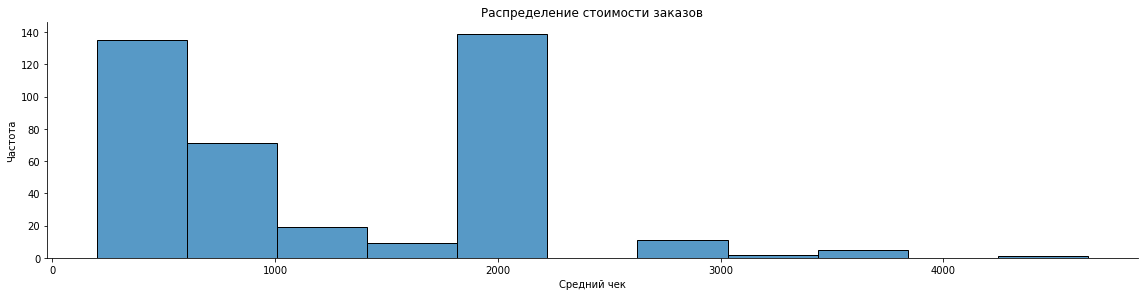

In [67]:
colors = {"0": "gray", "1": "Orange"}
sns.displot(data=experiment_users_data_notna_rev, x="rev", palette=colors.values(), height=4, aspect=4)
plt.title('Распределение стоимости заказов')
plt.xlabel('Средний чек')
plt.ylabel('Частота')

Посмотрим на распределение стоиомсти заказов по группам.

Text(4.928312174479181, 0.5, 'Частота')

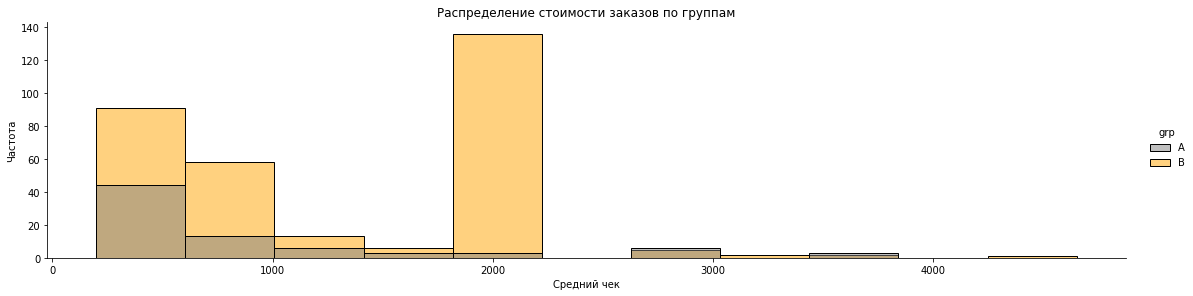

In [68]:
colors = {"0": "gray", "1": "Orange"}
sns.displot(data=experiment_users_data_notna_rev, x="rev", hue="grp", palette=colors.values(), height=4, aspect=4)
plt.title('Распределение стоимости заказов по группам')
plt.xlabel('Средний чек')
plt.ylabel('Частота')

**Violinplot**

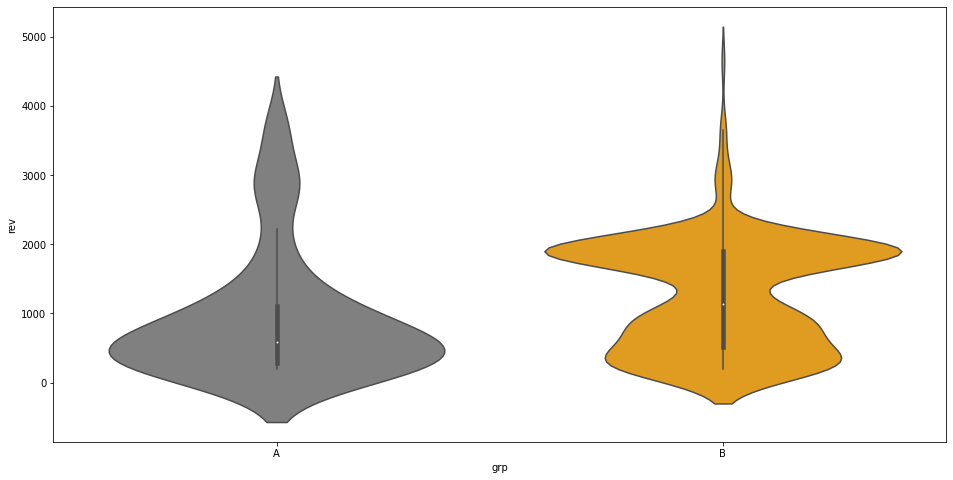

In [69]:
plt.figure(figsize=(16, 8))
colors = {"0": "gray", "1": "Orange"}
sns.violinplot(x='grp', y='rev', data=experiment_users_data_notna_rev, palette=colors.values())

**Q-Q plot**

In [70]:
group_0 = experiment_users_data_notna_rev.query('grp in "A"').rev
group_1 = experiment_users_data_notna_rev.query('grp in "B"').rev

Text(0, 0.5, 'Наблюдаемые квантили')

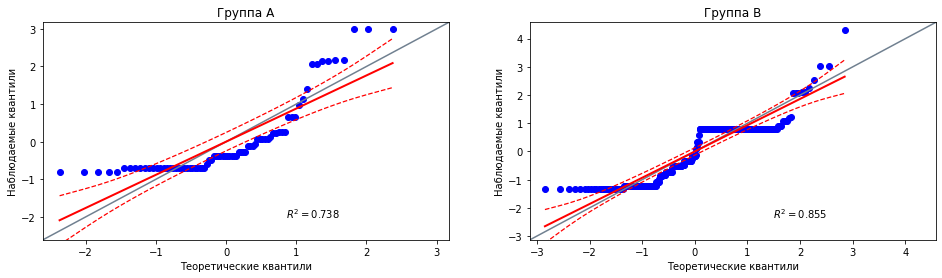

In [71]:
# Создаем фигуру с 1 строкой и 2 столбцами
fig, axes = plt.subplots(1, 2, figsize=(16, 4))  # Измените размер по вашему усмотрению

# Строим квантиль-квантиль графики на каждой из подсеток
pg.qqplot(group_0, dist='norm', ax=axes[0])  # График 1 в первой подсетке
pg.qqplot(group_1, dist='norm', ax=axes[1])  # График 2 во второй подсетке

# Настройте заголовки и метки осей, если это необходимо
axes[0].set_title('Группа А')
axes[1].set_title('Группа В')
axes[0].set_xlabel('Теоретические квантили')
axes[1].set_xlabel('Теоретические квантили')
axes[0].set_ylabel('Наблюдаемые квантили')
axes[1].set_ylabel('Наблюдаемые квантили')

**Тест Шапиро-Уилка**

In [72]:
# method Shapiro-Wilk test(default)
pg.normality(experiment_users_data_notna_rev, dv='rev', group='grp')

,W,pval,normal
A,0.735324,1.498682e-10,False
B,0.854724,1.543702e-16,False


**Вывод нормальности распределения**

По результатам оценки, распределение стоимости заказов по отдельному пользователю для старого и нового механизма оплаты отлично от нормального. Кроме того, согласно графику `violinplot` форма распределений групп А и В отличается. Наблюдается смещение тенденции в сторону увеличения стоимости заказа.

**Проверка гомоскедастичности (равенства дисперсий)**

In [73]:
homoscedasticity_test = pg.homoscedasticity(experiment_users_data_notna_rev, dv='rev', group='grp')

In [74]:
homoscedasticity_test

,W,pval,equal_var
levene,3.075682,0.080257,True


**Вывод о равенстве дисперсий**

pval > 0.05, не достаточно оснований отклонить нулевую гипотезу о равенстве дисперсий между группами.

**Выбор метода для проверки гипотезы**

Поскольку распределение наблюдений в группах не прошли проверку на соответствие нормальному, форма распределений в группах отличается, принято в качестве метода проверки гипотезы использовать бутстрап на основе библиотеки `pingouin`, а точнее разновидность `plot_shift`.

In [75]:
# Начиная с версии NumPy 19.0, необходимо указывать dtype=object при создании массива из "неровных" последовательностей.
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Вывод графика сдвига квантильного распределения

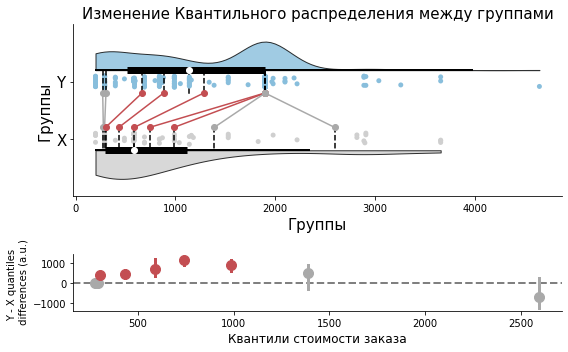

In [76]:
fig = pg.plot_shift(experiment_users_data_notna_rev.query('grp in "A"').rev,
                    experiment_users_data_notna_rev.query('grp in "B"').rev,
                    paired=False,
                    n_boot=10000, show_median=True, seed=456,
                    violin=True)
fig.axes[0].set_xlabel("Группы")
fig.axes[0].set_ylabel("Группы", size=15)
fig.axes[0].set_title("Изменение Квантильного распределения между группами", size=15)
fig.axes[1].set_xlabel("Квантили стоимости заказа", size=12)
plt.tight_layout()

**Вывод по пункту 1.3.3:**
- Последовательность процентилей для вычисления, по умолчанию установлено значение [10, 20, 30, 40, 50, 60, 70, 80, 90].
- Красные точки означают статистически значимые различия при изменении стоимости заказа. Наблюдается смещение кванитлей в сторону увеличения стоимости заказа, как следствие увеличения среднего чека.
- В гпуппе X(A) 5 красных точек соедененны линиями с 4 красными точками группе Y(B). Уменьшение красных точек в группе Y свидетельствет о изменении разброса значений.
- Наличие статистически значемых измененией в размере чеков позволяет утверджать, что введение нового механизма оплаты повлияло на среджний чек, принимаем H1.

## Заключение

**Конверсия по пункту 1.3.2:**

- Ни один из выполненных тестов хи-квадрат не показал статистически значимого влияния новой механики оплаты курсов на конверсию\
(pval > 0.05).
- Следовательно не достаточно оснований, чтобы отклонить нулевую гипотизу (Н0).
- Настоящая выборка **не позволяет** задетектированить статистически значимое влияние новой механики оплаты на изменение конверсии и принять (H1).
- Возможно искомый размер эффекта меньше значений которые можно задетектировать при данной выборке.

**Средний чек по пункту 1.3.3:**
- Последовательность процентилей для вычисления, по умолчанию установлено значение [10, 20, 30, 40, 50, 60, 70, 80, 90].
- Красные точки означают статистически значимые различия при изменении стоимости заказа. Наблюдается смещение кванитлей в сторону увеличения стоимости заказа, как следствие увеличения среднего(медианного) чека.
- В гпуппе X(A) 5 красных точек соедененны линиями с 4 красными точками группе Y(B). Уменьшение красныех точек в группе Y свидетельствет о изменении разброса значений.
- Следовательно достаточно оснований утверджать, что введение нового механизма оплаты повлияло на среджний чек, принимаем H1.

**Общее заключение**

1. По результатам проведения тестов относительно конверсии в покупку, новая механика оплаты не оказала влияния на результат.


2. Зафиксированы стастистически значимые изменения среднего чека.
    - при рассмотрении распределения часть пользователей, которые ранее делали заказы на относительно небольшие суммы сместились в сторону увеличения стоимости заказа.
    - изменился разборос значений стоимости заказов, увеличилось число заказов в группе В на сумму примерно 1900 по сравнения с группой А со старой механикой оплаты, где пиковое значение приходилось примерно на 400.


3. Различия в показателях могут быть связаны с новой механикой оплаты. Поскольку по результатам конверсия не изменилась, т.е. пропорция покупающих пользователей осталось примерно на прежнем уровне. Предположим, что нововведение заключалось в снижени стоимости товаров при увеличении количества товаров в корзине, за счет чего произошло увеличение среднего чека. Также одним из возможных факторов, нарушение в работе сиситемы сплиттования, которая изначально выбрала не похожие друг на друга группы. Следовательно, чтобы удостовериться в результате, необходиио верефецировться с результатами АА теста.


4. Поскольку негативные последствия нововведения в ходе исследования не выявлены, рекомендуется применить новую мехнику оплаты на всех пользователях.

## Задание 2. SQL
### 2.1 Очень усердные ученики

#### 2.1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц **правильно** решил 20 горошин.

#### 2.1.2 Задача

Дана таблица `default.peas`:


    
| Название атрибута | Тип атрибута | Смысловое значение                     |
|:-------------------|:-------------|:-------------------------------------|
| st_id             | int          | ID ученика                             |
| timest            | timestamp    | Время решения карточки                 |
| correct           | bool         | Правильно ли решена горошина?         |
| subject           | text         | Дисциплина, в которой находится горошина |
    





Необходимо написать **оптимальный** запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

**2.1.3 Формирование запроса**

Обратим внимание на формулировку задания "Под усердным студентом мы понимаем студента, который правильно решил 20 задач **за текущий месяц**."

Поскольку в данных clickhouse `default.peas` содержиться информаци только с 2021-10-30 по 2021-10-31. По определению информация на момент 2023 года отсутствует. Предлагается варинт с учетом не актуальности данных, который определить крайний месяц в датасете.

~~~~sql
-- Блок WITH для определения начала "текущего месяца"
WITH(
    SELECT
        toStartOfMonth(MAX(timest))
    FROM
        default.peas
    ) AS to_day
    

-- Внешний запрос, который вычисляет уникальное количество усердных студентов
SELECT
    uniqExact(hardworking_students) AS count_hardworking_students
FROM
    (
    -- Внутренний запрос (вложенный подзапрос):
    SELECT
        st_id AS hardworking_students,          -- Псевдоним для столбца st_id
        SUM(correct) AS Number_peas             -- Вычисление суммы правильных решений для каждого студента
    FROM
        default.peas                            -- Исходная таблица
    WHERE
        toStartOfMonth(timest) = to_day         -- Фильтрация по началу текущего месяца
    GROUP BY
        hardworking_students                    -- Группировка данных по студентам
    HAVING
        Number_peas >= 20                       -- Фильтрация по количеству правильных решений (больше или равно 20)
    )
~~~~

### 2.2 Оптимизация воронки

#### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

#### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs:



| Название атрибута | Тип атрибута | Смысловое значение          |
|:-------------------|:-------------|:---------------------------|
| st_id             | int          | ID ученика                 |
| test_grp          | text         | Метка ученика в эксперименте |




Название атрибута	Тип атрибута	Смысловое значение


| Название атрибута | Тип атрибута | Смысловое значение            |
|:-------------------|:-------------|:-----------------------------|
| st_id             | int          | ID ученика                    |
| sale_time         | timestamp    | Время покупки                 |
| money             | int          | Цена, по которой приобрели курс |
| subject           | text         |                              |

	
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

**2.2.3 Описание метрик**

Рассмотрим подробнее каждую из метрик:

1. **ARPU** (Average Revenue Per User):
    - Определение: Средний доход с пользователя.
    - Расчёт: ARPU = (Общий доход / Общее количество пользователей)


2. **ARPAU** (Average Revenue Per Active User):
    - Определение: Средний доход с активного пользователя.
    - Расчёт: ARPAU = (Общий доход / Количество активных пользователей)


3. **CR в покупку** (Conversion Rate в покупку):
    - Определение: Процент пользователей, купивших курс.
    - Расчёт: CR в покупку = (Количество пользователей с покупками / Количество пользователей)


4. **CR активного пользователя в покупку** (Conversion Rate активного пользователя в покупку):
    - Определение: Процент активных пользователей, перешедших от активности к покупке.
    - Расчёт: CR активного пользователя в покупку = (Количество активных пользователей с покупками / Количество активных пользователей)


5. **CR пользователя из активности по математике в покупку курса по математике**:
    - Определение: Процент пользователей, активность которых в математике привела к покупке курса по математике.
    - Расчёт: CR пользователя из активности по математике в покупку курса по математике = (Количество пользователей с покупками курса по математике / Количество пользователей с активностью по математике)

**2.2.3 Формирование запроса**

~~~~sql
SELECT
    -- Расчет метрик для control, pilot групп
    test_grp,
    SUM(sum_check) / COUNT(st_id) AS ARPU,
    SUM(sum_check) / COUNT(CASE WHEN Active_students_Number_peas != 0 THEN st_id END) AS ARPAU,
    COUNT(CASE WHEN sum_check != 0 THEN st_id END) / COUNT(st_id) AS CR,
    COUNT(CASE WHEN sum_check != 0  AND  Active_students_Number_peas != 0 THEN st_id END) / COUNT(CASE WHEN Active_students_Number_peas != 0 THEN st_id END) AS CR_Active_students,
    COUNT(CASE WHEN sum_check_Math != 0  AND  Active_students_math_Number_peas != 0 THEN st_id END) / COUNT(CASE WHEN Active_students_math_Number_peas != 0 THEN st_id END) AS CR_Active_students_math    
FROM
    (
    SELECT
        l.st_id AS st_id,
        l.test_grp AS test_grp,
        l.Active_students_Number_peas AS Active_students_Number_peas,
        l.Active_students_math_Number_peas AS Active_students_math_Number_peas,
        l.sum_check AS sum_check,
        r.sum_check_Math AS sum_check_Math
    FROM
        (
        SELECT
            l.st_id AS st_id,
            l.test_grp AS test_grp,
            l.Active_students_Number_peas AS Active_students_Number_peas,
            l.Active_students_math_Number_peas AS Active_students_math_Number_peas,
            r.sum_check AS sum_check
        FROM
            (
            SELECT
                Active_students_data.st_id AS st_id,
                Active_students_data.test_grp AS test_grp,
                Active_students_data.Active_students_Number_peas AS Active_students_Number_peas,
                Active_students_math_data.Number_peas AS Active_students_math_Number_peas
            FROM
                (
                SELECT
                    grp.st_id AS st_id,
                    grp.test_grp AS test_grp,
                    Active_students_data.Number_peas AS Active_students_Number_peas
                FROM
                    default.studs AS grp
                -- 2. Объединение таблицы с данными о граппах (control, pilot) через LEFT JOIN с данными об Активных студентах
                LEFT JOIN 
                        (
                         -- 1. Активне студенты внутренний запрос (вложенный подзапрос):
                         SELECT
                             st_id AS st_id,                -- Псевдоним для столбца st_id
                             SUM(correct) AS Number_peas    -- Вычисление суммы правильных решений для каждого студента
                         FROM
                             default.peas                   -- Исходная таблица по решениям
                         GROUP BY
                             st_id                          -- Группировка данных по студентам
                         HAVING
                             Number_peas > 10               -- Фильтрация по количеству правильных решений (больше 10)
                        ) AS Active_students_data
                ON grp.st_id = Active_students_data.st_id
                ) AS Active_students_data
            -- 3. Объединение таблицы с данными о граппах и Активных студентах через LEFT JOIN с данными об Активных студентах по математике
            LEFT JOIN
                (
                -- Активне студенты по математике внутренний запрос (вложенный подзапрос):
                SELECT
                    st_id AS Active_students_math_id,       -- Псевдоним для столбца st_id
                    SUM(correct) AS Number_peas             -- Вычисление суммы правильных решений для каждого студента
                FROM
                    default.peas                            -- Исходная таблица по решениям
                WHERE
                    subject = 'Math'                        -- Фильтрация по предмету математика
                GROUP BY
                    Active_students_math_id                 -- Группировка данных по студентам
                HAVING                                      -- Фильтрация по количеству правильных решений по матиматике (равным 2 и более)
                    Number_peas >= 2
                ) AS Active_students_math_data
            ON Active_students_data.st_id = Active_students_math_data.Active_students_math_id
            ) AS l
        -- 4. Объединение таблицы с данными о граппах, Активных студентах и Активных студентах по математике через LEFT JOIN с данными о продажах
        LEFT JOIN
            (
            -- Пользователи, купившие курс внутренний запрос (вложенный подзапрос):
            SELECT
                st_id,
                SUM(money) AS sum_check                     -- Вычисление суммарного чека отдельного пользователя
            FROM
                default.final_project_check                 -- Исходная таблица по продажам
            GROUP BY
                st_id                                       -- Группировка данных по студентам
            ) AS r         
        ON l.st_id = r.st_id
        ) AS l
    -- 5. Объединение таблицы с данными о граппах, Активных студентах, Активных студентах по математике, Пользователях купивших курс через LEFT JOIN с данными о пользователях купивших курс по математике  
    LEFT JOIN
        (
        -- Пользователи, купившие курс по математике внутренний запрос (вложенный подзапрос):
        SELECT
            st_id,
            SUM(money) AS sum_check_Math                     -- Вычисление суммарного чека отдельного пользователя
        FROM
            default.final_project_check                      -- Исходная таблица по продажам
        WHERE
            subject = 'Math'                                 -- Фильтрация по предмету математика
        GROUP BY
            st_id                                            -- Группировка данных по студентам
        ) AS r
    ON l.st_id = r.st_id
    )
GROUP BY
    test_grp
~~~~

## Задание 3. Python
### 3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

### Функция загрузки исходных данных и пересчета метрик

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [77]:
def recalculate_metrics(groups, active_studs, checks):
    
    """
    Функция для пересчета метрик на основе данных о группах, активных студентах и транзакциях.

    Параметры:
    - groups: pandas.DataFrame
        Данные о принадлежности пользователя к контрольной или экспериментальной группе.
    - active_studs: pandas.DataFrame
        Данные о пользователях, которые зашли на платформу в дни проведения эксперимента.
    - checks: pandas.DataFrame
        Данные об оплатах пользователей в дни проведения эксперимента.

    Возвращает:
    pandas.DataFrame
        Датафрейм с пересчитанными метриками, включая конверсию в покупку (CR).
    """
    
    # Импорт исходных данных
    
    base_url                            = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # Вписываем ссылку  
    public_key_groups_add               = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ' # groups_add.csv

    # Получаем загрузочную ссылку  
    final_url_groups_add                = base_url + urlencode(dict(public_key=public_key_groups_add))
    response                            = requests.get(final_url_groups_add) # запрос ссылки на скачивание
    download_url_groups_add             = response.json()['href'] # 'парсинг' ссылки на скачивание
    
    # Поскольку предполагается, что у нас заведомо есть предстваление о основных данных groups
    # (т.е. состоит из id пользователя и распределения по группам)
    # структура groups_add будет похожа, хотя названия мтолбцов могут отличаться.
    
    # Загружаем файл и сохраняем
    groups_add                          = pd.read_csv(download_url_groups_add, names=groups.columns)

    # Объединение данных
    concat_groups = pd.concat([groups, groups_add],  axis=0)

    # Объедение concat_groups с active_studs через left
    experiment_users_data = pd.merge(active_studs, 
                                     concat_groups, 
                                     left_on  = active_studs.columns[0],
                                     right_on = concat_groups.columns[0], 
                                     how      = 'left')\
                              .drop(columns=f'{concat_groups.columns[0]}')
    
    # Объедение experiment_users_data с checks через left
    experiment_users_data = pd.merge(experiment_users_data, 
                                     checks, 
                                     left_on  = experiment_users_data.columns[0],
                                     right_on = checks.columns[0], 
                                     how      = 'left')
    
    # Расчет метрик
    
    # Конверсия в покупку (CR)
    
    # Создание столбца в зависимости от значения в столбце rev
    experiment_users_data['rev_bin'] = np.where(experiment_users_data.iloc[:, 2].isna(), 0, 1)
    
    # Группировка данных по принадлежности к группам и транзакциям
    count_users = experiment_users_data.groupby([experiment_users_data.columns[1], 'rev_bin'], as_index=False)\
                                       .agg({experiment_users_data.columns[0]: 'count'})\
                                       .rename(columns={experiment_users_data.columns[0]: 'count_users'})
    
    # Данные с произведенной оплатой, т.е. rev_bin = 1
    count_paying_users = count_users[ count_users['rev_bin'] == 1 ].drop(columns={'rev_bin'})\
                                                                   .rename(columns={'count_users': 'count_paying_users'})
    # Количество пользователей в каждой группе
    A = experiment_users_data.grp.value_counts()[1]
    B = experiment_users_data.grp.value_counts()[0]
    
    # Расчет конверсии в зависимости от принадлежности к группе
    count_paying_users['CR'] = count_paying_users.apply(lambda x: x['count_paying_users'] / A 
                                                        if        x[experiment_users_data.columns[1]] == 'A' 
                                                        else      x['count_paying_users'] / B, axis=1)
    
    # Округление до 3 знака после разделителя
    count_paying_users.CR = round(count_paying_users.CR, 3)
    
    
    # Средний чек
    
    # Группировка данных по принадлежности к группам и транзакциям
    mean_check = experiment_users_data.groupby([experiment_users_data.columns[1], 'rev_bin'], as_index=False)\
                                      .agg({'rev': 'mean'})\
                                      .rename(columns={'rev': 'mean_check'})\
                                      .round(1)
    
    # Данные с произведенной оплатой, т.е. rev_bin = 1
    mean_check = mean_check[ mean_check['rev_bin'] == 1 ].drop(columns={'rev_bin'})
    
    # Объединение расчитанных метрик в единый DataFrame
    metrics = pd.merge(count_paying_users, mean_check, on=experiment_users_data.columns[1])
    
    # Вывод результата
    return metrics

In [78]:
metrics = recalculate_metrics(groups=groups, active_studs=active_studs, checks=checks)
metrics

,grp,count_paying_users,CR,mean_check
0,A,78,0.051,933.6
1,B,313,0.046,1255.8


### Функция визуализации метрик

2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_bar_plot_with_customization(data, 
                                       color_A="gray",
                                       color_B="orange",
                                       title_1=None, 
                                       title_2=None,
                                       x_label=None, 
                                       y_label=None,
                                       legend_1=None,
                                       legend_2=None,
                                       annotate=True,
                                       x_size=14,
                                       y_size=8,
                                       h_CR=0.0005,
                                       h_mean_check=10,                                       
                                       decimal_places_CR=3,
                                       decimal_places_mean_check=1):
    
    """
    Создает настраиваемую столбчатую диаграмму с двумя подграфиками: один для конверсии (CR) и второй для среднего чека.
    Столбец с группами должен быть первым.

    Параметры:
    - data: DataFrame, входные данные для построения графика.
    - color_A: str, цвет для первой группы.
    - color_B: str, цвет для второй группы.
    - title_1: str, заголовок для первого подграфика (CR).
    - title_2: str, заголовок для второго подграфика (средний чек).
    - x_label: str, подпись оси x.
    - y_label: str, подпись оси y.
    - legend_1: str, подпись легенды для первой группы.
    - legend_2: str, подпись легенды для второй группы.
    - annotate: bool, добавлять ли аннотации с значениями столбцов.
    - x_size: int, ширина всего графика.
    - y_size: int, высота всего графика.
    - h_CR: float, высота для аннотаций CR.
    - h_mean_check: float, высота для аннотаций среднего чека.
    - decimal_places_CR: int, количество десятичных знаков для аннотаций CR.
    - decimal_places_mean_check: int, количество десятичных знаков для аннотаций среднего чека.
    
    """
    
    # Визуализация конверсии (CR)
    x_column = data.columns[0]
    y_columns = data.columns[1:]

    y_CR = 'CR'
    if y_CR in y_columns:
        h_CR = h_CR
    
    y_mean_check = 'mean_check'
    if y_mean_check in y_columns:
        h_mean_check = h_mean_check
        
    colors = {data[x_column].unique()[0]: color_A, 
              data[x_column].unique()[1]: color_B}
    
    # Визуализация конверсии (CR)
    plt.figure(figsize=(x_size, y_size))
    ax_CR = plt.subplot(1, 2, 1)
    sns.barplot(data=data, x=x_column, y=y_CR, palette=colors.values(), saturation=0.9)

    # Настройка графика
    if title_1 is not None:
        plt.title(title_1)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    # Настройка легенды
    if legend_1 and legend_2 is not None:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=legend_1 if color == color_A else legend_2) for color in colors.values()]
        plt.legend(handles=legend_labels, title='Легенда')
    else:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label if color == color_A else label) for label, color in colors.items()]
        plt.legend(handles=legend_labels, title='Легенда')
    
    # Добавление аннотаций со значениями столбцов
    if annotate:
        for p in ax_CR.patches:
            value = round(p.get_height(), decimal_places_CR)
            ax_CR.annotate(f'{value:.{decimal_places_CR}f}', (p.get_x() + p.get_width() / 2., p.get_height() + h_CR),
                           ha='center', va='baseline', fontsize=12, color='black')
    
    # Визуализация среднего чека
    ax_mean_check = plt.subplot(1, 2, 2)
    sns.barplot(data=data, x=x_column, y=y_mean_check, palette=colors.values(), saturation=0.9)

    # Настройка графика
    if title_2 is not None:
        plt.title(title_2)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    # Настройка легенды
    if legend_1 and legend_2 is not None:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=legend_1 if color == color_A else legend_2) for color in colors.values()]
        plt.legend(handles=legend_labels, title='Легенда')
    else:
        legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=label if color == color_A else label) for label, color in colors.items()]
        plt.legend(handles=legend_labels, title='Легенда')
    
    # Добавление аннотаций со значениями столбцов
    if annotate:
        for p in ax_mean_check.patches:
            value = round(p.get_height(), decimal_places_mean_check)
            ax_mean_check.annotate(f'{value:.{decimal_places_mean_check}f}', (p.get_x() + p.get_width() / 2., p.get_height() + h_mean_check),
                                   ha='center', va='baseline', fontsize=12, color='black')

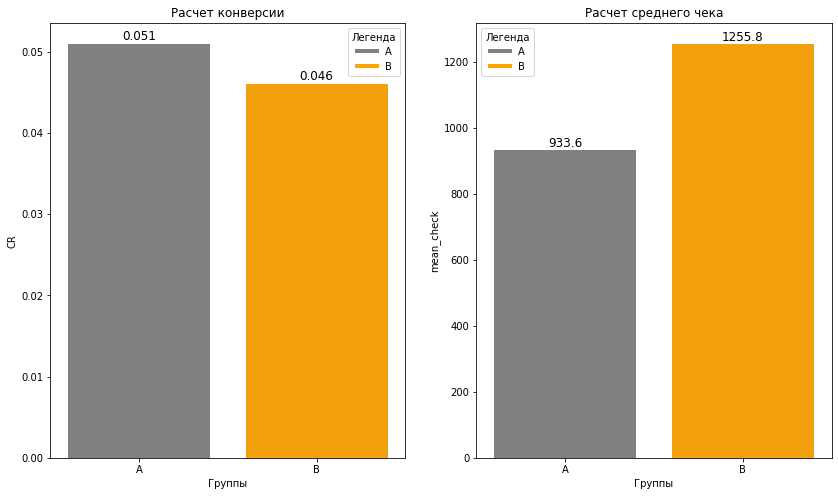

In [80]:
create_bar_plot_with_customization(data=metrics, 
                                   title_1='Расчет конверсии',  
                                   title_2='Расчет среднего чека', 
                                   x_label='Группы')